In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import time

# Problem 1

## Preamble

In [59]:
# Replace with file path of Problem1.csv if not in the same folder as this notebook
prob1_fp = 'Problem1.csv'

# Import data
prob1_df = pd.read_csv(prob1_fp, header=None, names=['x1','x2','y'])

# Set up problem parameters and vectors
n, p, x1, x2, y = prob1_df.shape[0], prob1_df.shape[1] - 1, prob1_df['x1'], prob1_df['x2'], prob1_df['y']
X = prob1_df[['x1','x2']]

# Preview the first 5 rows
prob1_df.head(5)

,x1,x2,y
0,0.65865,-0.75245,1
1,0.53805,-0.84291,1
2,-0.34941,-0.93697,-1
3,0.56989,-0.82172,1
4,-0.42218,-0.90651,-1


## Problem 1 Q1 - Plotting

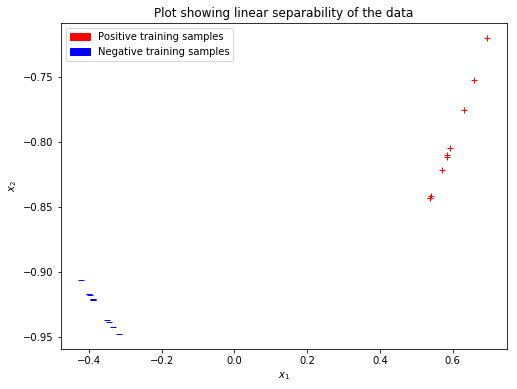

In [60]:
fig_prob1q1, ax = plt.subplots(1, figsize=(8,6))
y_marker = {1: 'r+', -1: 'b_'}
ax.set_title(r'Plot showing linear separability of the data')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

red_patch = mpatches.Patch(color='red', label='Positive training samples')
blue_patch = mpatches.Patch(color='blue', label='Negative training samples')
plt.legend(handles=[red_patch, blue_patch])

for t in range(0,n):
    plt.plot(x1[t],x2[t],y_marker[y[t]])

plt.savefig("problem1_q1", dpi=300, bbox_inches='tight') # Exports the figure
plt.show()

## Problem 1 Q2 - Finding max-margin solution using SVM

* We recommend using the *quadprog* module in conjuction with the below function (which is just a convenient wrapper) to solve the SVM optimization. Before running the below cell, install Python package *quadprog* by opening anaconda command prompt and running:

   *pip install quadprog*
   
   
* You can use other optimization packages such as CVXOPT or CVXPY if you are able to install them correctly (if you are using later versions of Python > 3.4 you may need to create virtual environment to install such packages)

* The below function solves a quadratic program:
        minimize
            (1/2) * x.T * P * x + q.T * x
        subject to
            G * x <= h
            A * x == b
            
* **Important:** You might encounter an error (even in other convex optimization software) that the objective matrix is not PD. A workaround is to perturb the matrix along the diagonal by a small positive epsilon.  

In [61]:
def calculate_gamma(X, y, theta, n):
    gamma = np.inf
    for t in range(0,n):
        gamma = min(gamma, y[t]*np.dot(theta,X.values[t]))
    return gamma

In [62]:
import quadprog

def quadprog_solve_qp(P, q, G=None, h=None, A=None, b=None, initvals=None):
    if initvals is not None:
        print("quadprog: note that warm-start values ignored by wrapper")
    qp_G = P
    qp_a = -q
    if A is not None:
        qp_C = -np.vstack([A, G]).T
        qp_b = -np.hstack([b, h])
        meq = A.shape[0]
    else:  # no equality constraint
        qp_C = -G.T
        qp_b = -h
        meq = 0
    return quadprog.solve_qp(qp_G, qp_a, qp_C, qp_b, meq)[0]

In [63]:
P = np.identity(p)
q = np.zeros(p)
G = -np.multiply(np.matrix(y).T,X)
h = -1*np.ones(n)

theta_star = quadprog_solve_qp(P, q, G=G, h=h) 
# Normalize theta
theta_star = (1.0/np.linalg.norm(theta_star)) * theta_star
# Calculate gamma_star
gamma_star = calculate_gamma(X, y, theta_star, n)

print('Problem 1 Q2 \n=================================')
print('theta^*: %s' % theta_star)
print('gamma^*: %s' % gamma_star)

Problem 1 Q2 
theta^*: [0.99257345 0.12164684]
gamma^*: 0.4314845982168759


## Problem 1 Q3 - Standard Perceptron Algorithm

### Problem 1 Q3(a)

In [64]:
## Std. Perceptron Implementation
"""
Parameters:
X: (n,p) feature matrix
y: n-vector of labels
theta_zero: initial theta

Returns:
k: # updates
theta_k: Converged (normalized) theta
gamma: margin for this theta_k
"""
def std_perceptron(X, y, theta_zero):   
    k = 0
    theta_k = theta_zero
    gamma = None    

    isSolution = False
    while isSolution == False:
        # raise exception if exceed 10000 iterations
        if k > 10000:
            raise Exception('exceeded 10000 iterations')
        isSolution = True
        for t in range(0,n):
            y_t = y[t]
            x_t = X.values[t] 
            if y[t]*np.dot(theta_k,x_t)<=0:
                theta_k = theta_k + y_t * x_t
                isSolution = False
                k += 1
    
    # Completed Perceptron - normalize theta and calculate gamma
    theta_k = np.multiply((1.0/np.linalg.norm(theta_k)),theta_k)
    gamma = calculate_gamma(X,y,theta_k,n)
                 
    return k, theta_k, gamma

In [65]:
## Run this to see results
theta_zero = np.zeros(p)
k, theta, gamma = std_perceptron(X, y, theta_zero)
print('Problem 1 Q3(a) \n=================================')
print("Number of updates, k = %s" % k)
print("theta = %s" % theta)
print("gamma = %s" % gamma)

Problem 1 Q3(a) 
Number of updates, k = 2
theta = [0.98365688 0.18005314]
gamma = 0.37745488374724534


### Problem 1 Q3(b)

In [66]:
num_iter = 10
for i in range(0,num_iter):
    # Generate theta_zero for each iteration and run perceptron
    theta_zero_i = np.random.rand(2)
    k_i, theta_i, gamma_i = std_perceptron(X, y, theta_zero_i)
    
    print('================= Iter %s =================' % i)
    print('theta_zero = %s' % theta_zero_i)
    print('k = %s, theta = [%.3f,%.3f], gamma=%.3f' % (k_i, theta_i[0], theta_i[1], gamma_i))

================= Iter 0 =================
theta_zero = [0.67360871 0.33054755]
k = 0, theta = [0.898,0.441], gamma=0.112
================= Iter 1 =================
theta_zero = [0.92907048 0.81037498]
k = 1, theta = [1.000,-0.022], gamma=0.297
================= Iter 2 =================
theta_zero = [0.68588925 0.28404271]
k = 0, theta = [0.924,0.383], gamma=0.175
================= Iter 3 =================
theta_zero = [0.18071892 0.05301995]
k = 0, theta = [0.960,0.282], gamma=0.279
================= Iter 4 =================
theta_zero = [0.89741097 0.7844022 ]
k = 1, theta = [0.999,-0.041], gamma=0.280
================= Iter 5 =================
theta_zero = [0.81425816 0.4654737 ]
k = 0, theta = [0.868,0.496], gamma=0.049
================= Iter 6 =================
theta_zero = [0.85759134 0.53144607]
k = 0, theta = [0.850,0.527], gamma=0.013
================= Iter 7 =================
theta_zero = [0.28672446 0.32191657]
k = 2, theta = [0.931,0.364], gamma=0.194
================= Iter

### Problem 1 Q3(d)

In [39]:
"""
Parameters:
d: dimension of the sphere

Returns:
random point from boundary of d-sphere
"""
def sample_unit_sphere(d):    
    # Generate a point from the boundary of a d-sphere
    x = np.random.normal(0.0,1.0,(d))
    norm_x = np.linalg.norm(x)
    point = x/norm_x

    return point    

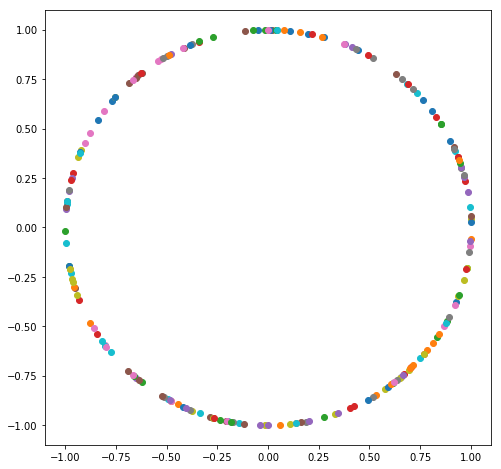

In [11]:
fig, ax = plt.subplots(1, figsize=(8,8))
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
for i in range(200):
    point = sample_unit_sphere(2)
    ax.scatter(point[0], point[1])
plt.show()

In [12]:
#Sample theta^{(0)} from the unit-circle at each round and run the std perceptron
k_vector, theta_vector, gamma_vector, theta_zero_vector = [], [], [], []
for i in range(10000):
    theta_zero_i = sample_unit_sphere(2)
    #record theta_zero
    theta_zero_vector.append(theta_zero_i)
    
    #run perceptron and record results
    k_i, theta_i, gamma_i = std_perceptron(X, y, theta_zero_i)
    k_vector.append(k_i)
    theta_vector.append(theta_i)
    gamma_vector.append(gamma_i)

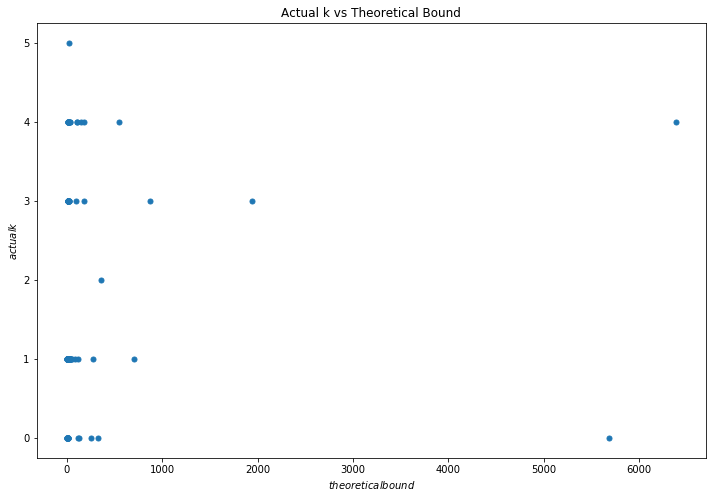

average of no. of updates over 10000 runs = 1.8079
average of gamma_star = 0.2464211670650252


In [13]:
fig_prob1q3d, ax = plt.subplots(1, figsize=(12,8))
ax.set_title(r'Actual k vs Theoretical Bound')

theo_vector = []

# Calculate theoretical bound for each theta_zero
for i in range(100):
    theta = theta_vector[i]
    theta_zero = theta_zero_vector[i]
    gamma = gamma_vector[i]
    a = np.dot(theta, theta_zero)
    theo_vector.append(max(-a/gamma, (1 - (2*a*gamma) + math.sqrt(math.pow(2*a*gamma - 1, 2) - 
                                                            (4 * math.pow(gamma,2) * (math.pow(a,2)-1)))) / (2*math.pow(gamma,2)) ))
# Plot actual k vs theoretical bound
ax.set_xlabel(r'$theoretical bound$')
ax.set_ylabel(r'$actual k$')
plt.plot(theo_vector, k_vector[:100],'o',markersize=5)
 
plt.savefig("problem1_q3d", dpi=300, bbox_inches='tight') # Exports the figure
plt.show()

# calculate average of k's and average of gamma's
print("average of no. of updates over 10000 runs = %s" % np.average(k_vector))
print("average of gamma_star = %s" % np.average(gamma_vector))

## Problem 1 Q4 - Linear Inseparability

In [46]:
# Modify dataset
y[0] = -1
y[2] = 1


C:\Users\Kai\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Kai\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


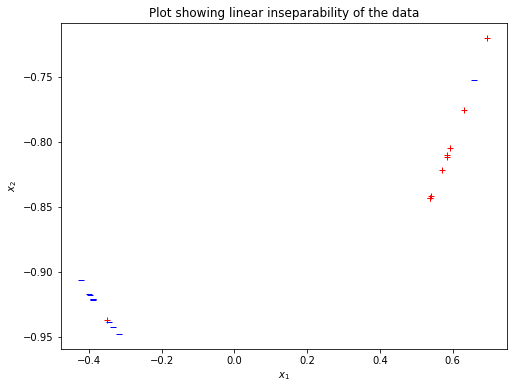

In [47]:
## Plotting
fig_prob1q4, ax = plt.subplots(1, figsize=(8,6))
y_marker = {1: 'r+', -1: 'b_'}
ax.set_title(r'Plot showing linear inseparability of the data')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

for t in range(0,n):
    plt.plot(x1[t],x2[t],y_marker[y[t]])

plt.savefig("problem1_q4", dpi=300, bbox_inches='tight') # Exports the figure
plt.show()

In [48]:
# Run SVM
G = -np.multiply(np.matrix(y).T,X)
#theta_star = quadprog_solve_qp(P, q, G=G, h=h) 

# Run Perceptron
theta_zero = np.random.rand(2)
k, theta, gamma = std_perceptron(X, y, theta_zero)

Exception: exceeded 100000 iterations

# Problem 2

## Preamble

In [18]:
# Replace with file path of iris1.csv if not in the same folder as this notebook
prob2_fp = 'iris1.csv'

# Import data
prob2_df = pd.read_csv(prob2_fp, header=None, names=['x1','x2','y'])

# Set up problem parameters and vectors
n, p, x1, x2, y = prob2_df.shape[0], prob2_df.shape[1] - 1, prob2_df['x1'], prob2_df['x2'], prob2_df['y']
X = prob2_df[['x1','x2']]

# Preview the first 5 rows
prob2_df.head(5)

,x1,x2,y
0,5.1,3.5,-1
1,4.9,3.0,-1
2,4.7,3.2,-1
3,4.6,3.1,-1
4,5.0,3.6,-1


## Problem 2 Q1

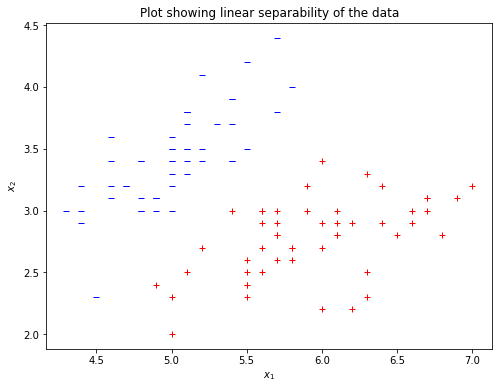

In [19]:
# Plot data
fig_prob2q1, ax = plt.subplots(1, figsize=(8,6))
y_marker = {1: 'r+', -1: 'b_'}
ax.set_title(r'Plot showing linear separability of the data')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')

for t in range(0,n):
    plt.plot(x1[t],x2[t],y_marker[y[t]])

plt.savefig("problem2_q1", dpi=300, bbox_inches='tight') # Exports the figure
plt.show()

## Problem 2 Q2

In [28]:
# Set matrices for quadprog
P = np.identity(p+1)
# make the last row a zero row so that we do not include the offset in the objective function; 
# however a matrix with zero row is not positive definite so use eps
for i in range(0,p+1):
    if i == p:
        P[i][i] = 3e-8
    else:
        P[i][i] = P[i][i] + 3e-8
q = np.zeros(p+1)
G = -1*np.concatenate((np.multiply(np.matrix(y).T,X),np.matrix(y).T),axis=1)
h = -1*np.ones(n)

start = time.clock()
theta_hardsvm = quadprog_solve_qp(P, q, G=G, h=h)
end = time.clock()
print("Time taken to solve primal problem: %s" % (end - start))
 
# Normalize theta
theta_star = theta_hardsvm[0:p]
theta_zero = theta_hardsvm[p]
obj_value = 0.5*math.pow(np.linalg.norm(theta_star),2)

print('Problem 2 Q2 \n=================================')
print('theta^*: %s' % theta_star)
print('theta_zero^*: %s' % theta_zero)
print('optimal objective value: %s' % obj_value)

Time taken to solve primal problem: 0.0002425967179391364
Problem 2 Q2 
theta^*: [ 6.31578947 -5.26315789]
theta_zero^*: -17.31578947378911
optimal objective value: 33.79501385068385


## Problem 2 Q3

In [28]:
SV = []
for i in range(n):    
    # Detect support vectors and append their indices into SV
    if y[i]*(np.dot(theta_star,X.values[i]) + theta_zero) <= 1 + 3e-8:
        SV.append(i)  

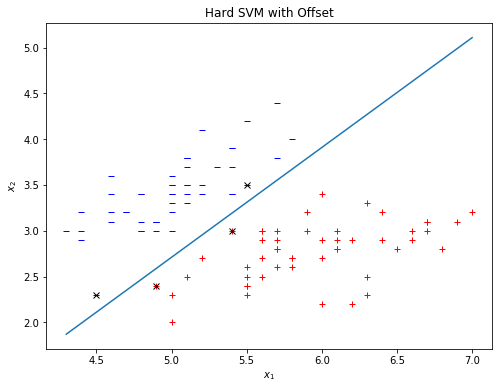

In [29]:
fig_prob2q3, ax = plt.subplots(1, figsize=(8,6))
y_marker = {1: 'r+', -1: 'b_'}
ax.set_title(r'Hard SVM with Offset')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
# Plot the original data
for t in range(0,n):
    plt.plot(x1[t],x2[t],y_marker[y[t]])

# Plot the decision boundary
min_x1 = min(x1)
max_x1 = max(x1)
min_x2 = (-theta_star[0]*min_x1 - theta_zero)/theta_star[1]
max_x2 = (-theta_star[0]*max_x1 - theta_zero)/theta_star[1]

plt.plot([min_x1,max_x1], [min_x2,max_x2])

# Indicate the support vectors                                    
for j in range(0,len(SV)):
    plt.plot(x1[SV[j]],x2[SV[j]],'kx')

plt.savefig("problem2_q3", dpi=300, bbox_inches='tight') # Exports the figure
plt.show()

## Problem 2 Q4

In [27]:
# Set up matrices
eps = 3e-8

Q = []
for i in range(0,n):
    temp = []
    for j in range(0,n):
        if i==j:
            temp.append(y[i]*y[j]*np.dot(X.values[i], X.values[j]) + eps)
        else:
            temp.append(y[i]*y[j]*np.dot(X.values[i], X.values[j]))
    Q.append(temp)
    
P = np.asarray(Q)
q = -np.ones(n)
G = -np.identity(n)  
h = np.zeros(n)
A = np.matrix(y)
b = [0]

start = time.clock()
theta_dual = quadprog_solve_qp(P, q, G, h, A, b)
end = time.clock()
print("Time taken to solve dual problem: %s" % (end - start))

results = []
for i in range(0,n):
    if abs(theta_dual[i]) >= 10e-6:
        # append the non-zero (>=10e-6) entries and their respective indices
        results.append([theta_dual[i], i])

# report results
print("Alpha_i and their indices: %s \n" % results)

# calculate optimal objective function value
opt_obj = 0
indices = []
for i in range(0,len(results)):
    indices.append(results[i][1])
    
for i in indices:
    opt_obj = opt_obj + theta_dual[i]
    for j in indices:
        if abs(theta_dual[i]) >=10e-6 and abs(theta_dual[j]) >=10e-6:
            opt_obj = opt_obj - 0.5*theta_dual[i]*theta_dual[j]*y[i]*y[j]*np.dot(X.values[i],X.values[j])

print("Optional objective function value: %s" % opt_obj)


Time taken to solve dual problem: 0.004495503796405842
Alpha_i and their indices: [[15.900268956553191, 36], [17.894727581879124, 41], [16.398883492860477, 57], [17.396112841146532, 84]] 

Optional objective function value: 33.79501739019088


## Problem 2 Q5

In [52]:
# Calculate the first sum
alpha_y_x = 0
for i in indices:
    alpha_y_x += theta_dual[i]*y[i]*X.values[i]
    
print("First sum: %s" % alpha_y_x) # this is also =theta_star

# Calculate the second sum
j = indices[0] # arbitrarily pick a j which satisfies aj > 0
alpha_y_xi_xj = y[j]

for i in indices:
    alpha_y_xi_xj -= theta_dual[i]*y[i]*np.dot(X.values[i], X.values[j])
    
print("Second sum: %s " % alpha_y_xi_xj) # this is also =theta_zero

First sum: [ 6.31578508 -5.26315588]
Second sum: -17.315772347562643 


# Problem 3

## Preamble

In [33]:
# Replace with file path of iris1.csv if not in the same folder as this notebook
prob3_fp = 'iris2.csv'

# Import data
prob3_df = pd.read_csv(prob3_fp, header=None, names=['x1','x2','x3','x4','y'])

# Set up problem parameters and vectors
n, p, X, y = prob3_df.shape[0], prob3_df.shape[1] - 1, prob3_df[['x1','x2','x3','x4']], prob3_df['y']

# Preview the first 5 rows
prob3_df.head(5)

,x1,x2,x3,x4,y
0,7.0,3.2,4.7,1.4,-1
1,6.4,3.2,4.5,1.5,-1
2,6.9,3.1,4.9,1.5,-1
3,5.5,2.3,4.0,1.3,-1
4,6.5,2.8,4.6,1.5,-1


## Problem 3 Q1 - Soft SVM

In [34]:
eps = 3e-8

def soft_svm(n,p,X,y,C):

    P = np.identity(p+1+n) # theta, theta_zero, epsilons
    # make the last (n+1) rows a zero row so that we only have theta in the objective function; 
    # however a matrix with zero rows is not positive definite so use eps
    for i in range(0,p+n+1):
        if i >= p:
            P[i][i] = eps
        else:
            P[i][i] = P[i][i] + eps

    q = C*np.concatenate((np.zeros(p+1), np.ones(n)))
    G = -1*np.concatenate((np.concatenate((np.multiply(np.matrix(y).T,X),np.matrix(y).T, np.identity(n)),axis=1), 
                           np.concatenate((np.zeros((n,p+1)),np.identity(n)), axis=1)), axis=0)
    h = -1*np.concatenate((np.ones(n), np.zeros(n)))

    theta_softsvm = quadprog_solve_qp(P, q, G=G, h=h)

    # Normalize theta
    theta_star = theta_softsvm[0:p]
    theta_zero = theta_softsvm[p]

    # count the no. of epsilon where epsilon >1
    num_misclassified_egs = 0
    for i in range(0,n):
        if y[i]*(np.dot(theta_star,X[i]) + theta_zero) < 0:
            num_misclassified_egs += 1

    obj_value = 0.5*math.pow(np.linalg.norm(theta_star),2)
    
    # add penalty term
    for j in range(p+1,n+p+1):
        epsilon_i = theta_softsvm[j]
        if abs(epsilon_i) >= 10e-6:
            obj_value += C*epsilon_i
    
    return theta_star, theta_zero, obj_value, num_misclassified_egs

# Run soft SVM
theta_star, theta_zero, obj_value, num_misclassified_egs = soft_svm(n,p,X.values,y,100)
print('Problem 3 Q1 \n=================================')
print('theta^*: %s' % theta_star)
print('theta_zero^*: %s' % theta_zero)
print('optimal objective value: %s' % obj_value)
print('no. of misclassified examples: %s' % num_misclassified_egs)

Problem 3 Q1 
theta^*: [-1.84782609 -3.26086957  4.67391304 10.86956522]
theta_zero^*: -20.413043478222097
optimal objective value: 654.1942344040862
no. of misclassified examples: 3


## Problem 3 Q2 - Cross-validation

In [14]:
C = [1,100,10000]
av_test_error_by_C = []
k = 10 # 10-fold cross validation
size_of_each_fold = n//k

# split the data into k folds (record the indices)
kf = []
for i in range(0,k):
    temp = []
    temp.append( list( range(i*10,(i+1)*10)) )
    temp.append( list(range(0,i*10)) + list(range((i+1)*10,100)) )
    kf.append(temp)

for c in C:
    test_errors = []
    
    # Perform 10-fold cross validation for this particular c, append the 10 errors into the test_errors vector#
    for j in range(0,10):
        dataset_indices = kf[j]
        test = dataset_indices[0]
        train = dataset_indices[1]
        train_data_X = np.array(X)[train]
        train_data_y = np.array(y)[train]
        test_data_X = np.array(X)[test]
        test_data_y = np.array(y)[test]
        
        # run SVM on training data
        theta_star, theta_zero, obj_value, num_misclassified_egs = soft_svm((k-1)*size_of_each_fold
                                                                            ,p,train_data_X,train_data_y,c)
        
        # calculate no. of misclassified test samples based on the trained SVM
        num_misclassified_test_samples = 0
        for i in range(0,size_of_each_fold):
            if test_data_y[i]*(np.dot(theta_star,test_data_X[i]) + theta_zero) < 0:
                num_misclassified_test_samples += 1
            
        # append the no. of misclassified test samples in this iteration
        test_errors.append(num_misclassified_test_samples)
    
    av_test_error = np.mean(test_errors)
    print('C = %s, Av. test error = %s' % (c, av_test_error))
    av_test_error_by_C.append(av_test_error)
    
print('Optimal C = %s' % C[np.argmin(av_test_error_by_C)])
              

C = 1, Av. test error = 0.4
C = 100, Av. test error = 0.6
C = 10000, Av. test error = 0.7
Optimal C = 1
